In [8]:
import pandas as pd
from textblob import TextBlob
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm
tqdm.pandas() #use: progress_apply() instead of apply()
from statistics import mean
from sklearn.utils import resample
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim
import scipy.sparse as sp
from transformers import pipeline
import spacy

In [2]:
# Loading the data
url='https://drive.google.com/file/d/1mqxv8AFExcVBryjJqk-m8aX_5mXzOi7O/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
df = pd.read_csv(url, encoding='UTF-8')

df.head()

,review_text,rating,branch_Disneyland California,branch_Disneyland Hong Kong,branch_Disneyland Paris,branch_Universal Studios Florida,branch_Universal Studios Japan,branch_Universal Studios Singapore,month,quarter,...,attendance_millions_2012,attendance_millions_2013,attendance_millions_2014,attendance_millions_2015,attendance_millions_2016,attendance_millions_2017,attendance_millions_2018,attendance_millions_2019,attendance_millions_2020,attendance_millions_2021
0,daughter spent sunny hot day disneyland hong k...,4,0,1,0,0,0,0,7,3,...,-0.44219,-0.376665,-0.467907,-0.78852,-0.877021,-0.924937,-0.888022,-1.078998,-1.132465,-1.042827
1,location infront mtr station time required cov...,5,0,1,0,0,0,0,11,4,...,-0.44219,-0.376665,-0.467907,-0.78852,-0.877021,-0.924937,-0.888022,-1.078998,-1.132465,-1.042827
2,spent day disneyland great time family friendl...,5,0,1,0,0,0,0,4,2,...,-0.44219,-0.376665,-0.467907,-0.78852,-0.877021,-0.924937,-0.888022,-1.078998,-1.132465,-1.042827
3,recent tour hong kong limited time choose diff...,5,0,1,0,0,0,0,5,2,...,-0.44219,-0.376665,-0.467907,-0.78852,-0.877021,-0.924937,-0.888022,-1.078998,-1.132465,-1.042827
4,hong kong young kid place go fun obviously pie...,5,0,1,0,0,0,0,4,2,...,-0.44219,-0.376665,-0.467907,-0.78852,-0.877021,-0.924937,-0.888022,-1.078998,-1.132465,-1.042827


In [13]:
nlp = spacy.load("en_core_web_sm")

# Define a function to compute the token length of a text
def get_token_length(text):
    doc = nlp(text)
    return len(doc)

# Apply the function to the text column to get the token length for each row
df['token_length'] = df['review_text'].apply(get_token_length)

KeyboardInterrupt: 

In [14]:
# Use boolean indexing to select the rows where the token length is less than 512
df_short_text = df[df['token_length'] < 512]

In [19]:
# Load pre-trained sentiment analysis model
sentiment_analysis = pipeline('sentiment-analysis', model='distilbert-base-uncased-finetuned-sst-2-english', truncation=True)

# Apply sentiment analysis to DataFrame
df_short_text['sentiment'] = df_short_text['review_text'][:100].progress_apply(lambda x: sentiment_analysis(x)[0]['label'])

100%|██████████| 100/100 [04:39<00:00,  2.79s/it]

                                             review_text  rating  \
0      daughter spent sunny hot day disneyland hong k...       4   
1      location infront mtr station time required cov...       5   
2      spent day disneyland great time family friendl...       5   
3      recent tour hong kong limited time choose diff...       5   
4      hong kong young kid place go fun obviously pie...       5   
...                                                  ...     ...   
90447  visit universal orlando brilliant experience p...       5   
90448  universal studio shall begin staff lovely ride...       5   
90449  split day two park 10 hour great fun staff ama...       5   
90450  definitely great ride experience jurassic park...       4   
90451  nice afternoon really enjoyed transformer mumm...       4   

       branch_Disneyland California  branch_Disneyland Hong Kong  \
0                                 0                            1   
1                                 0            


C:\Users\16479\AppData\Local\Temp\ipykernel_7796\1880293822.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_short_text['sentiment'] = df_short_text['review_text'][:100].progress_apply(lambda x: sentiment_analysis(x)[0]['label'])


POSITIVE    62
NEGATIVE    38
Name: sentiment, dtype: int64


<Axes: >

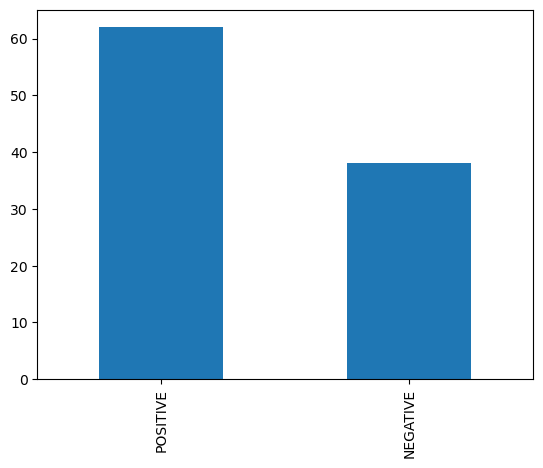

In [28]:
print(df_short_text['sentiment'].value_counts())
df_short_text['sentiment'].value_counts().plot.bar()

In [33]:
# Define function to apply to each element of the DataFrame
def get_sentiment(x):
    if x >= 3:
        return 'POSITIVE'
    else:
        return 'NEGATIVE'

# Apply function to each element of the DataFrame and store results in new column
df_short_text['original_sentiment'] = df_short_text["rating"].apply(get_sentiment)

C:\Users\16479\AppData\Local\Temp\ipykernel_7796\2067905503.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_short_text['original_sentiment'] = df_short_text["rating"].apply(get_sentiment)


POSITIVE    95
NEGATIVE     5
Name: original_sentiment, dtype: int64


<Axes: >

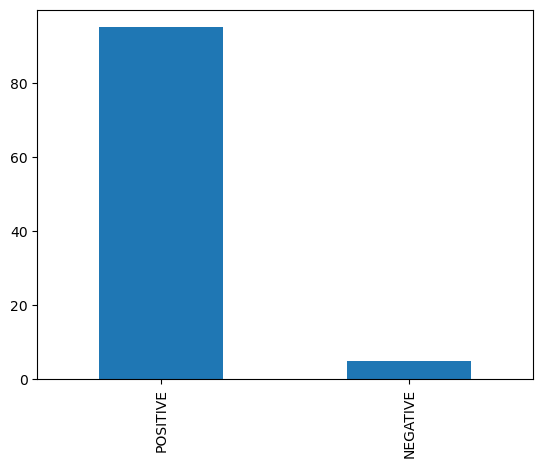

In [35]:
print(df_short_text['original_sentiment'][:100].value_counts())
df_short_text['original_sentiment'][:100].value_counts().plot.bar()

In [43]:
print(classification_report(df_short_text['original_sentiment'][:100],df_short_text['sentiment'][:100]))
print(confusion_matrix(df_short_text['original_sentiment'][:100],df_short_text['sentiment'][:100]))

              precision    recall  f1-score   support

    NEGATIVE       0.13      1.00      0.23         5
    POSITIVE       1.00      0.65      0.79        95

    accuracy                           0.67       100
   macro avg       0.57      0.83      0.51       100
weighted avg       0.96      0.67      0.76       100

[[ 5  0]
 [33 62]]


In [ ]:
'''
precision = measures quality of positive predictions -> detect false positive -> low means bad predictor, lots of false positives
recall = measures true positive -> detect false negative -> low means bad predictor, lots of false negatives /
//correct predictions
'''